<a href="https://colab.research.google.com/github/NikhitapHegde/final_year_project/blob/main/Brain_tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
from tqdm import tqdm

manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [1]:
from google.colab import files

# Upload the ZIP file
uploaded = files.upload()

Saving archive (4).zip to archive (4).zip


In [2]:
import zipfile
import os

# Define the name of the uploaded ZIP file
zip_file_name = 'archive (4).zip'  # Change this if your file has a different name

# Extract the ZIP file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall('extracted_files')

print("Files extracted to: extracted_files/")

Files extracted to: extracted_files/


In [3]:
dataroot ='extracted_files/brain_tumor_dataset'

workers = 2
batch_size = 64
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 2000
lr = 0.0002
beta1 = 0.5
ngpu = 1

dataloader:  <enumerate object at 0x7fc4ee574480>


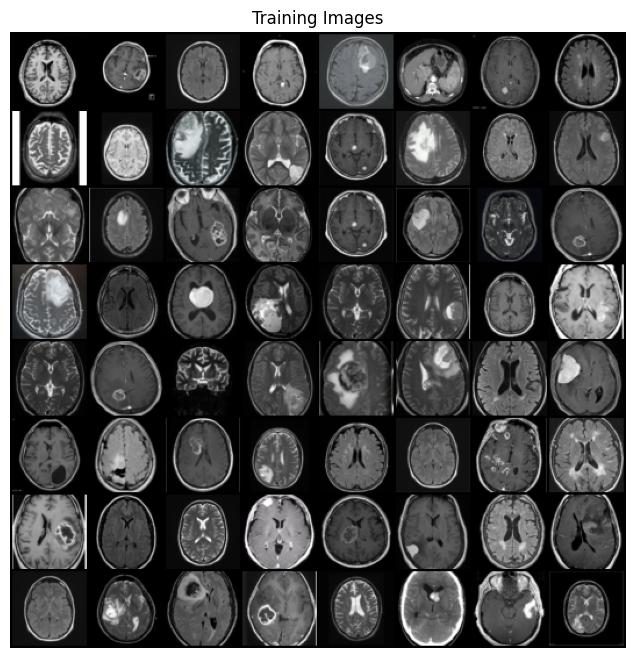

In [6]:

dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)
print("dataloader: ", enumerate(dataloader))

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [7]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(

            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

             nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()

        )

    def forward(self, input):
        return self.main(input)

In [9]:
netG = Generator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
netG.apply(weights_init)

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [11]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(

            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

             nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [12]:
netD = Discriminator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
netD.apply(weights_init)

print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [13]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [14]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        iters += 1

        if iters % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if (epoch == 300):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

            output_path = '/kaggle/working/DCGAN_results_epoch_300/'
            if not os.path.exists(output_path):
                os.makedirs(output_path)

            for i in range(64):
                vutils.save_image(fake[i], '%s/fake_samples_epoch_300_%d.png' %
                                  (output_path, i), normalize=True)

Starting Training Loop...
[12/2000][1/4]	Loss_D: 2.8015	Loss_G: 21.5171	D(x): 0.9956	D(G(z)): 0.8644 / 0.0000
[24/2000][3/4]	Loss_D: 0.1726	Loss_G: 6.1501	D(x): 0.9216	D(G(z)): 0.0604 / 0.0046
[37/2000][1/4]	Loss_D: 0.2450	Loss_G: 6.4162	D(x): 0.9163	D(G(z)): 0.1087 / 0.0023
[49/2000][3/4]	Loss_D: 0.1569	Loss_G: 6.6538	D(x): 0.9219	D(G(z)): 0.0645 / 0.0017
[62/2000][1/4]	Loss_D: 0.0559	Loss_G: 8.3191	D(x): 0.9780	D(G(z)): 0.0324 / 0.0003
[74/2000][3/4]	Loss_D: 0.6163	Loss_G: 4.2595	D(x): 0.6699	D(G(z)): 0.0029 / 0.0328
[87/2000][1/4]	Loss_D: 0.1447	Loss_G: 19.4383	D(x): 0.9312	D(G(z)): 0.0002 / 0.0003
[99/2000][3/4]	Loss_D: 0.1712	Loss_G: 9.8000	D(x): 0.8804	D(G(z)): 0.0002 / 0.0001
[112/2000][1/4]	Loss_D: 0.1059	Loss_G: 7.9615	D(x): 0.9162	D(G(z)): 0.0018 / 0.0008
[124/2000][3/4]	Loss_D: 0.1621	Loss_G: 9.3244	D(x): 0.9702	D(G(z)): 0.1159 / 0.0002
[137/2000][1/4]	Loss_D: 0.0447	Loss_G: 6.4620	D(x): 0.9705	D(G(z)): 0.0132 / 0.0021
[149/2000][3/4]	Loss_D: 0.2910	Loss_G: 14.2027	D(x): 0.9

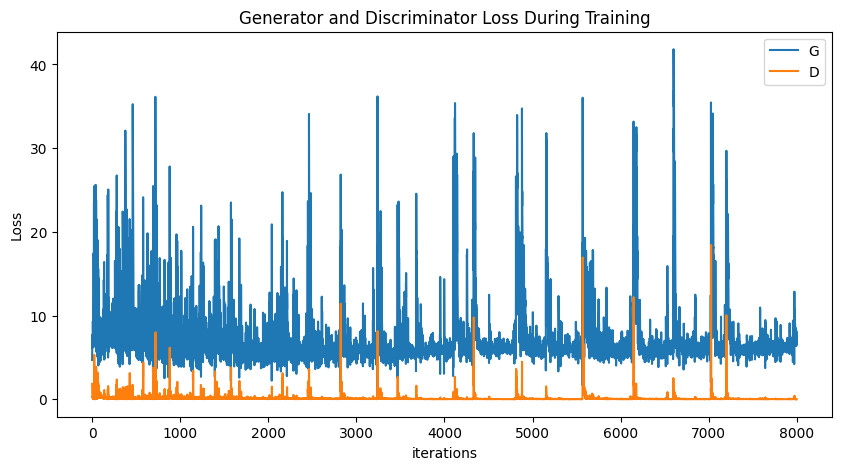

In [15]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

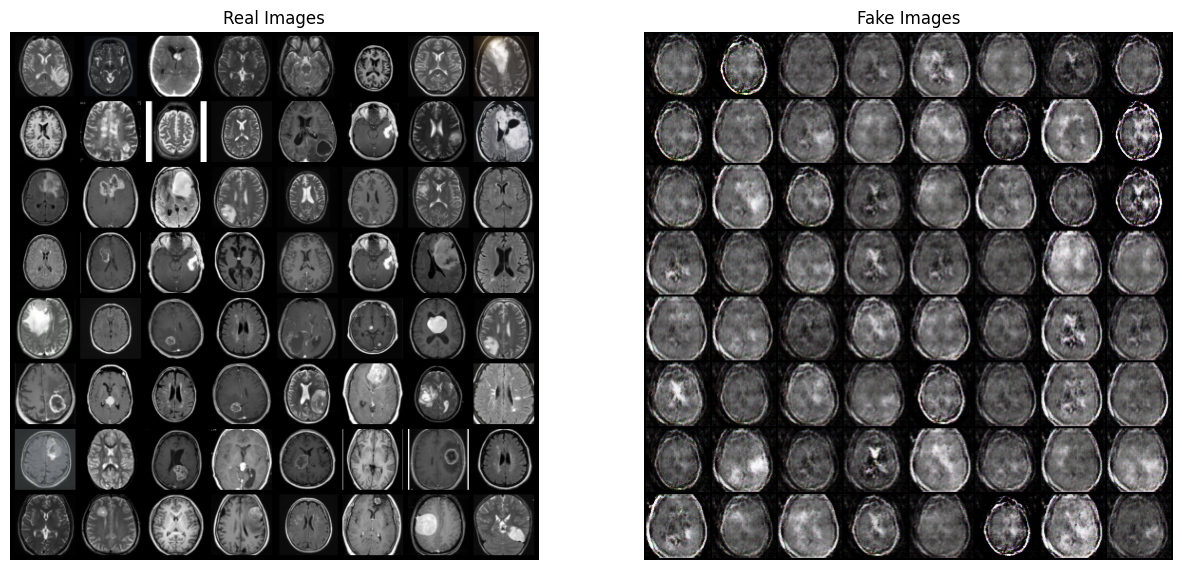

In [16]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))


plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [17]:
import os
import torch
import torchvision.utils as vutils

# Initialize necessary variables
img_list = []
G_losses = []
D_losses = []
iters = 0

# Parameters for image generation
num_images_to_generate = 3000  # Total number of images desired
images_per_batch = 64          # Number of images per batch
save_frequency = num_images_to_generate // images_per_batch  # Number of intervals to save images

# Output directory for images
output_path = 'extracted_files/DCGAN_results/'
if not os.path.exists(output_path):
    os.makedirs(output_path)

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # Train Discriminator
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # Train Generator
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        iters += 1

        # Print loss and metrics every 50 iterations
        if iters % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Save generated images at defined intervals
        if iters % save_frequency == 0:
            with torch.no_grad():
                noise = torch.randn(images_per_batch, nz, 1, 1, device=device)
                fake = netG(noise).detach().cpu()
            for idx in range(images_per_batch):
                vutils.save_image(fake[idx], '%s/fake_sample_%d_iter_%d.png' %
                                  (output_path, idx + iters, epoch), normalize=True)

print("Training Completed. Images saved in:", output_path)


Starting Training Loop...
[12/2000][1/4]	Loss_D: 0.2442	Loss_G: 18.2220	D(x): 0.9904	D(G(z)): 0.1566 / 0.0000
[24/2000][3/4]	Loss_D: 0.0162	Loss_G: 17.4238	D(x): 0.9884	D(G(z)): 0.0037 / 0.0020
[37/2000][1/4]	Loss_D: 0.0357	Loss_G: 6.8579	D(x): 0.9972	D(G(z)): 0.0321 / 0.0020
[49/2000][3/4]	Loss_D: 0.0910	Loss_G: 4.2000	D(x): 0.9420	D(G(z)): 0.0048 / 0.0274
[62/2000][1/4]	Loss_D: 0.0127	Loss_G: 6.4824	D(x): 0.9929	D(G(z)): 0.0054 / 0.0022
[74/2000][3/4]	Loss_D: 0.0249	Loss_G: 5.6545	D(x): 0.9802	D(G(z)): 0.0031 / 0.0054
[87/2000][1/4]	Loss_D: 0.0199	Loss_G: 6.2261	D(x): 0.9915	D(G(z)): 0.0111 / 0.0031
[99/2000][3/4]	Loss_D: 0.0322	Loss_G: 6.1749	D(x): 0.9980	D(G(z)): 0.0295 / 0.0026
[112/2000][1/4]	Loss_D: 0.0277	Loss_G: 5.2998	D(x): 0.9775	D(G(z)): 0.0036 / 0.0085
[124/2000][3/4]	Loss_D: 0.0118	Loss_G: 6.0428	D(x): 0.9977	D(G(z)): 0.0094 / 0.0034
[137/2000][1/4]	Loss_D: 0.0121	Loss_G: 5.8969	D(x): 0.9981	D(G(z)): 0.0102 / 0.0042
[149/2000][3/4]	Loss_D: 0.0067	Loss_G: 6.6936	D(x): 0.99

In [20]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Paths
data_dir = "extracted_files/DCGAN_results/"
train_dir = "extracted_files/train/"
test_dir = "extracted_files/test/"

# Example: Assume all images belong to one class ('class_0')
class_name = "class_0"

# Create train and test directories with class subdirectories
os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

# List all images
all_images = [f for f in os.listdir(data_dir) if f.endswith('.png')]

# Split into train and test sets
train_images, test_images = train_test_split(all_images, test_size=0.2, random_state=42)

# Move files into respective class subdirectories
for img in train_images:
    shutil.copy(os.path.join(data_dir, img), os.path.join(train_dir, class_name))

for img in test_images:
    shutil.copy(os.path.join(data_dir, img), os.path.join(test_dir, class_name))

print(f"Train images: {len(train_images)}, Test images: {len(test_images)}")


Train images: 8857, Test images: 2215


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Hyperparameters
batch_size = 32
learning_rate = 0.001
num_epochs = 10
num_classes = 10  # Adjust based on your classification task

# Data transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [22]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Testing loop
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Epoch [1/10], Loss: 0.0082
Epoch [2/10], Loss: 0.0000
Epoch [3/10], Loss: 0.0000
Epoch [4/10], Loss: 0.0000
Epoch [5/10], Loss: 0.0000
Epoch [6/10], Loss: 0.0000
Epoch [7/10], Loss: 0.0000
Epoch [8/10], Loss: 0.0000
Epoch [9/10], Loss: 0.0000
Epoch [10/10], Loss: 0.0000
Test Accuracy: 100.00%


In [36]:
import os
import shutil
import random

# Define source directories for the extracted data
train_dir = 'extracted_files/train/'
test_dir = 'extracted_files/test/'

# Define the destination directory (DCGAN folder structure)
output_dir = 'DCGAN_results/'

# Create the final directory structure (train, val, test, class_0, class_1)
os.makedirs(os.path.join(output_dir, 'train/class_0'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'train/class_1'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'val/class_0'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'val/class_1'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'test/class_0'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'test/class_1'), exist_ok=True)

# Function to split and copy images
def split_and_copy(src_dir, output_dir, split_ratio=(0.7, 0.2, 0.1)):
    # Get all class directories in the source directory
    class_dirs = [d for d in os.listdir(src_dir) if os.path.isdir(os.path.join(src_dir, d))]

    for class_dir in class_dirs:
        class_path = os.path.join(src_dir, class_dir)
        all_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

        # Shuffle the files for randomness
        random.shuffle(all_files)

        # Calculate the number of files for each set based on the split ratio
        num_files = len(all_files)
        num_train = int(num_files * split_ratio[0])
        num_val = int(num_files * split_ratio[1])
        num_test = num_files - num_train - num_val  # The rest goes to the test set

        # Split the files into train, val, and test
        train_files = all_files[:num_train]
        val_files = all_files[num_train:num_train + num_val]
        test_files = all_files[num_train + num_val:]

        # Define destination paths for train, val, and test
        train_dest = os.path.join(output_dir, 'train', class_dir)
        val_dest = os.path.join(output_dir, 'val', class_dir)
        test_dest = os.path.join(output_dir, 'test', class_dir)

        # Create the directories if they don't exist
        os.makedirs(train_dest, exist_ok=True)
        os.makedirs(val_dest, exist_ok=True)
        os.makedirs(test_dest, exist_ok=True)

        # Copy files to the respective directories
        for file in train_files:
            shutil.copy(os.path.join(class_path, file), os.path.join(train_dest, file))
        for file in val_files:
            shutil.copy(os.path.join(class_path, file), os.path.join(val_dest, file))
        for file in test_files:
            shutil.copy(os.path.join(class_path, file), os.path.join(test_dest, file))

# Split and copy images from both the train and test directories
split_and_copy(train_dir, output_dir)
split_and_copy(test_dir, output_dir)

print(f"Dataset has been successfully split into train, val, and test directories in {output_dir}.")


Dataset has been successfully split into train, val, and test directories in DCGAN_results/.


Found 7749 images belonging to 2 classes.
Found 2214 images belonging to 2 classes.
Found 1109 images belonging to 2 classes.


<ipython-input-40-b943efff7db9>:62: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 68s 110ms/step - accuracy: 0.9657 - loss: 0.0725 - val_accuracy: 1.0000 - val_loss: 1.2874e-04
Epoch 2/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 1.0000 - loss: 3.0667e-05 - val_accuracy: 1.0000 - val_loss: 9.2315e-05
Epoch 3/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 59s 87ms/step - accuracy: 1.0000 - loss: 1.0366e-04 - val_accuracy: 1.0000 - val_loss: 2.5618e-05
Epoch 4/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 7.8832e-06 - val_accuracy: 1.0000 - val_loss: 3.2209e-05
Epoch 5/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 81s 86ms/step - accuracy: 1.0000 - loss: 6.8600e-05 - val_accuracy: 1.0000 - val_loss: 8.4299e-06
Epoch 6/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 0s 54us/step - accuracy: 1.0000 - loss: 7.9128e-06 - val_accuracy: 1.0000 - val_loss: 6.7752e-06
Epoch 7/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 42s 86ms/step - accuracy: 1.0000 - loss: 1.9181e-05 - val_accuracy: 1.0000 - val_loss: 2.95

Test Accuracy: 100.00%


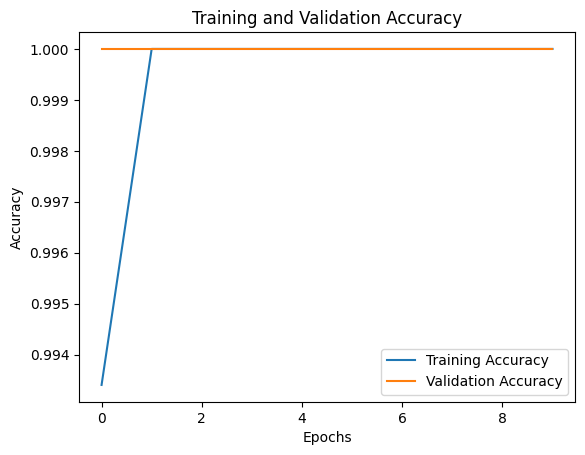

In [40]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import mixed_precision

# Set mixed precision for faster training on supported hardware (Optional)
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Set up directories for training, validation, and test data
train_dir = 'DCGAN_results/train'
val_dir = 'DCGAN_results/val'
test_dir = 'DCGAN_results/test'

# Set image dimensions
img_height = 120  # Image height
img_width = 120   # Image width
batch_size = 16   # Reduced batch size for faster training

# Set up data generators with image augmentation for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators for training, validation, and testing
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'  # Binary classification (class_0 vs class_1)
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

# Use MobileNetV2 for transfer learning with pre-trained weights
base_model = MobileNetV2(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Define the model using MobileNetV2 as base
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

# Compile the model
model.compile(
    loss='binary_crossentropy',  # Binary cross-entropy for binary classification
    optimizer=Adam(learning_rate=0.0001),  # Adam optimizer with a small learning rate
    metrics=['accuracy']  # Track accuracy during training
)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,  # Train for 10 epochs (you can adjust this as needed)
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Optionally, save the trained model
model.save('dcgan_model.h5')

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [31]:
import os

# Check if images exist in the directories
train_images = os.listdir(train_dir)
val_images = os.listdir(val_dir)
test_images = os.listdir(test_dir)

print("Train Images:", train_images)
print("Validation Images:", val_images)
print("Test Images:", test_images)

# Check if they are valid image files
valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff']
train_images = [f for f in train_images if any(f.endswith(ext) for ext in valid_extensions)]
val_images = [f for f in val_images if any(f.endswith(ext) for ext in valid_extensions)]
test_images = [f for f in test_images if any(f.endswith(ext) for ext in valid_extensions)]

print("Valid Train Images:", train_images)
print("Valid Validation Images:", val_images)
print("Valid Test Images:", test_images)


Train Images: ['fake_sample_5520_iter_1368.png', 'fake_sample_2730_iter_666.png', 'fake_sample_4969_iter_1230.png', 'fake_sample_3993_iter_988.png', 'fake_sample_1112_iter_264.png', 'fake_sample_6919_iter_1724.png', 'fake_sample_6703_iter_1667.png', 'fake_sample_5144_iter_1276.png', 'fake_sample_1852_iter_448.png', 'fake_sample_4366_iter_1080.png', 'fake_sample_5405_iter_1345.png', 'fake_sample_4592_iter_1138.png', 'fake_sample_4649_iter_1161.png', 'fake_sample_6668_iter_1655.png', 'fake_sample_2748_iter_678.png', 'fake_sample_1668_iter_402.png', 'fake_sample_5608_iter_1391.png', 'fake_sample_7903_iter_1966.png', 'fake_sample_2586_iter_632.png', 'fake_sample_2678_iter_666.png', 'fake_sample_2861_iter_701.png', 'fake_sample_600_iter_149.png', 'fake_sample_6175_iter_1529.png', 'fake_sample_3048_iter_758.png', 'fake_sample_7570_iter_1885.png', 'fake_sample_1020_iter_252.png', 'fake_sample_7095_iter_1759.png', 'fake_sample_7370_iter_1839.png', 'fake_sample_3828_iter_954.png', 'fake_sample_

In [30]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm  # Importing tqdm for progress bar

# Directories for train, validation, and test data
train_dir = 'processed_dataset/train'
val_dir = 'processed_dataset/val'
test_dir = 'processed_dataset/test'

# Define transformations (resize, convert to tensor, normalize)
transform = transforms.Compose([
    transforms.Resize((64, 64)),        # Resize to a fixed size (e.g., 64x64)
    transforms.ToTensor(),              # Convert images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize with mean=0.5 and std=0.5
])

def is_valid_file(path):
    # Check if the file is a valid image file by trying to open it with PIL
    try:
        img = Image.open(path)
        img.verify()  # Verify that it is, in fact an image
        return True
    except (IOError, SyntaxError) as e:
        print('Bad file:', path)  # Print out the names of corrupt files
        return False

# Datasets (for train, validation, and test)
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# DataLoaders (for batching the data)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 64 * 64, 128)  # Adjust based on input size and layers
        self.fc2 = nn.Linear(128, 2)  # Assuming binary classification (e.g., 'class_0' and 'class_1')

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(torch.relu(self.conv2(x)), 2)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model = SimpleCNN()

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10  # Number of epochs for training
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Progress bar for the training loop
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as pbar:
        for inputs, labels in pbar:
            # Move inputs and labels to the device (GPU if available)
            inputs, labels = inputs.cuda(), labels.cuda()

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update progress bar description
            pbar.set_postfix(loss=running_loss/total, accuracy=100 * correct / total)

    # Print detailed accuracy for each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, "
          f"Train Accuracy: {100 * correct / total:.2f}%")

# Validation loop with progress bar
model.eval()  # Set model to evaluation mode
val_correct = 0
val_total = 0

with torch.no_grad():  # No need to compute gradients during evaluation
    with tqdm(val_loader, desc="Validation", unit="batch") as pbar:
        for inputs, labels in pbar:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

# Print detailed validation accuracy
print(f"Validation Accuracy: {100 * val_correct / val_total:.2f}%")

# Testing loop with progress bar
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    with tqdm(test_loader, desc="Testing", unit="batch") as pbar:
        for inputs, labels in pbar:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

# Print detailed test accuracy
print(f"Test Accuracy: {100 * test_correct / test_total:.2f}%")


FileNotFoundError: Found no valid file for the classes class_0. Supported extensions are: .jpg, .jpeg, .png, .ppm, .bmp, .pgm, .tif, .tiff, .webp